# 2D case - Figure 10
Two-parameter 2D problem - Investigation of  the  convergence  of  the  reduced-order model and of the evolution of the size of the reduced-order basis.

## Libraries import  

In [14]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

## Load the config file

In [15]:
    Configuration_file = 'Configurations/config_2D_ROM.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [16]:

# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )


# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  unknown version

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           224



fatal: No names found, cannot describe anything.


## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [17]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]],
                                    [   config["parameters"]["para_2_min"],
                                        config["parameters"]["para_2_max"],
                                        config["parameters"]["N_para_2"]]])

## Initialisation of the surrogate model

In [18]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [19]:
ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

ROM_model.TrainingParameters(   
                                loss_decrease_c = config["training"]["loss_decrease_c"], 
                                Max_epochs = config["training"]["n_epochs"], 
                                learning_rate = config["training"]["learning_rate"]
                            )

ROM_model.train()                                                                   # Put the model in training mode
ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)         


* Refinement level: 0

**************** START TRAINING ***************

epoch 100 loss = -3.84094e-04 modes = 1
epoch 200 loss = -1.25423e-03 modes = 1
epoch 300 loss = -2.28241e-03 modes = 1
epoch 400 loss = -3.36762e-03 modes = 1
epoch 500 loss = -3.98543e-03 modes = 1
epoch 600 loss = -4.16658e-03 modes = 1
epoch 700 loss = -4.20485e-03 modes = 1
epoch 800 loss = -4.22419e-03 modes = 2
epoch 900 loss = -4.81514e-03 modes = 2
epoch 1000 loss = -5.22749e-03 modes = 2
epoch 1100 loss = -5.33319e-03 modes = 2
epoch 1200 loss = -5.36082e-03 modes = 2
epoch 1300 loss = -5.37012e-03 modes = 2
*************** END FIRST PHASE ***************

* Training time: 5.19122576713562s
* Saving time: 0.0s
* Evaluation time: 2.8538825511932373s
* Backward time: 2.096078872680664s
* Update time: 0.17574310302734375s
* Average epoch time: 0.0039061141964903084s
************** START SECOND PAHSE *************

epoch 5 loss = -5.3769e-03
*************** END OF TRAINING ***************

* Training time: 5.

## Plotting area

Reproducing figure 10

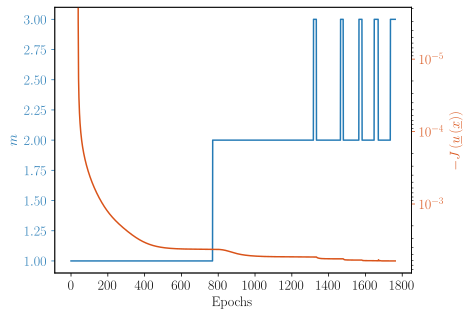

<Figure size 640x480 with 0 Axes>

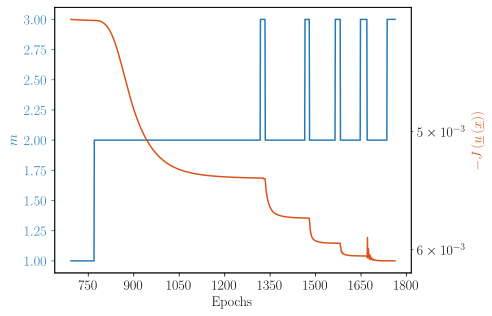

<Figure size 640x480 with 0 Axes>

In [20]:
tikz = False
Zoom_required = True

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


Modes_flag = ROM_model.training_recap["Mode_vect"]
error = ROM_model.training_recap["Loss_vect"]
name = 'Fig10'

fig = plt.figure()
ax = fig.add_subplot(111)
g1 = ax.plot(Modes_flag, color='#247ab5ff')
ax.tick_params(axis='y', colors='#247ab5ff')
plt.ylabel(r'$m$',color='#247ab5ff')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Epochs')
ax2 = ax.twinx()

ax2.invert_yaxis()
g2 = ax2.semilogy(-torch.tensor(error), color='#d95319ff')
ax2.set_ylabel(r'$ - J\left(\underline{u}\left(\underline{x}\right)\right)$',color='#d95319ff')

ax2.tick_params(axis='y', colors='#d95319ff')

lns = g1+g2
labs = [l.get_label() for l in lns]
if tikz:
    import tikzplotlib
    tikzplotlib.save('Results/'+name+'.tex')
plt.savefig('Results/'+name+'.pdf', transparent=True, bbox_inches = "tight")

plt.show()
plt.clf() 

if Modes_flag[0] == Modes_flag[-1]:
    Zoom_required = False

if Zoom_required:
    import numpy as np
    Zoom_depth = np.min(np.where(np.array(Modes_flag) == np.array(Modes_flag)[0]+1))
    Zoom_start_index = int(np.floor(0.9*Zoom_depth))
    second_stages_epochs = len(error) - len(Modes_flag)
    Modes_flag.extend([Modes_flag[-1]]*second_stages_epochs)
    x_indexes = np.arange(len(Modes_flag[Zoom_start_index:]))+Zoom_start_index
    fig = plt.figure()
    ax = fig.add_subplot(111)
    g1 = ax.plot(x_indexes,Modes_flag[Zoom_start_index:], color='#247ab5ff')
    ax.tick_params(axis='y', colors='#247ab5ff')
    plt.ylabel(r'$m$',color='#247ab5ff')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel(r'Epochs')
    ax2 = ax.twinx()

    ax2.invert_yaxis()
    g2 = ax2.semilogy(x_indexes,-torch.tensor(error[Zoom_start_index:]), color='#d95319ff')
    ax2.set_ylabel(r'$ - J\left(\underline{u}\left(\underline{x}\right)\right)$',color='#d95319ff')

    # g2 = ax2.semilogy(-torch.tensor(error),label = r'$ - J\left(\underline{u}\left(\underline{x}\right)\right)$', color='#d95319ff')
    ax2.tick_params(axis='y', colors='#d95319ff')

    lns = g1+g2
    labs = [l.get_label() for l in lns]
    # ax.legend(lns, labs, loc="upper center")
    if tikz:
        import tikzplotlib
        tikzplotlib.save('Results/'+name+'_zoom.tex')
    plt.savefig('Results/'+name+'_zoom.pdf', transparent=True, bbox_inches = "tight")


    plt.show() 
    plt.clf() 
